In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function

import os
import sys
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.applications.imagenet_utils import preprocess_input

sys.path.append(os.path.dirname(os.path.abspath(''))) # sys.path.append('..') # sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
from utils import display_examples, angle_error, RotNetDataGenerator, binarize_images

## Train model

In [3]:
# we don't need the labels indicating the digit value, so we only load the images
(X_train, _), (X_test, _) = mnist.load_data()

In [4]:
model_name = 'rotnet_mnist_anna'

# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
# number of classes
nb_classes = 360

nb_train_samples, img_rows, img_cols = X_train.shape
img_channels = 1
input_shape = (img_rows, img_cols, img_channels)
nb_test_samples = X_test.shape[0]

In [5]:
print('Input shape:', input_shape)
print(nb_train_samples, 'train samples')
print(nb_test_samples, 'test samples')

Input shape: (28, 28, 1)
60000 train samples
10000 test samples


In [6]:
# model definition
input = Input(shape=(img_rows, img_cols, img_channels))
x = Conv2D(nb_filters, kernel_size, activation='relu')(input)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(nb_classes, activation='softmax')(x)

In [7]:
model = Model(inputs=input, outputs=x)

model.summary()

# model compilation
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[angle_error])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                             

In [5]:
os.listdir(os.path.join('models'))

['rotnet_mnist_anna.hdf5']

In [8]:
# training parameters
batch_size = 128
nb_epoch = 50

output_folder = 'models'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# callbacks
checkpointer = ModelCheckpoint(
    filepath=os.path.join(output_folder, model_name + '.hdf5'),
    save_best_only=True
)
early_stopping = EarlyStopping(patience=2)
tensorboard = TensorBoard()

In [9]:
# training loop
model.fit(
    RotNetDataGenerator(
        X_train,
        batch_size=batch_size,
        preprocess_func=binarize_images,
        shuffle=True
    ),
    steps_per_epoch=nb_train_samples / batch_size,
    epochs=nb_epoch,
    validation_data=RotNetDataGenerator(
        X_test,
        batch_size=batch_size,
        preprocess_func=binarize_images
    ),
    validation_steps=nb_test_samples / batch_size,
    verbose=1,
    callbacks=[checkpointer, early_stopping, tensorboard]
)

<ipython-input-9-bf958b3772e1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
468/468 [==============================] - 191s 402ms/step - loss: 5.0421 - angle_error: 81.6874 - val_loss: 4.3810 - val_angle_error: 66.1724
Epoch 2/50
468/468 [==============================] - 190s 406ms/step - loss: 4.3283 - angle_error: 65.2490 - val_loss: 3.9357 - val_angle_error: 55.5902
Epoch 3/50
468/468 [==============================] - 192s 409ms/step - loss: 4.0482 - angle_error: 56.9952 - val_loss: 3.7281 - val_angle_error: 47.4194
Epoch 4/50
468/468 [==============================] - 190s 406ms/step - loss: 3.9106 - angle_error: 53.0798 - val_loss: 3.6017 - val_angle_error: 45.2458
Epoch 5/50
173/468 [==========>...................] - ETA: 1:57 - loss: 3.8197 - angle_error: 50.0987

KeyboardInterrupt: 

## Load data

In [10]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Load model

In [11]:
model_location = os.path.join('..', 'models', 'rotnet_mnist_anna.hdf5')
model = load_model(model_location, custom_objects={'angle_error': angle_error})

NameError: name 'load_model' is not defined

## Evaluate model

In [8]:
batch_size = 128
out = model.evaluate(
    RotNetDataGenerator(
        X_test,
        batch_size=batch_size,
        preprocess_func=binarize_images,
        shuffle=True
    ), 
    steps=len(y_test) / batch_size
)

print('Test loss:', out[0])
print('Test angle error:', out[1])

78/78 [==============================] - 7s 93ms/step - loss: 5.5923 - angle_error: 73.3983
Test loss: 5.592341423034668
Test angle error: 73.3983383178711


## Display examples

1/1 [==============================] - 0s 62ms/step


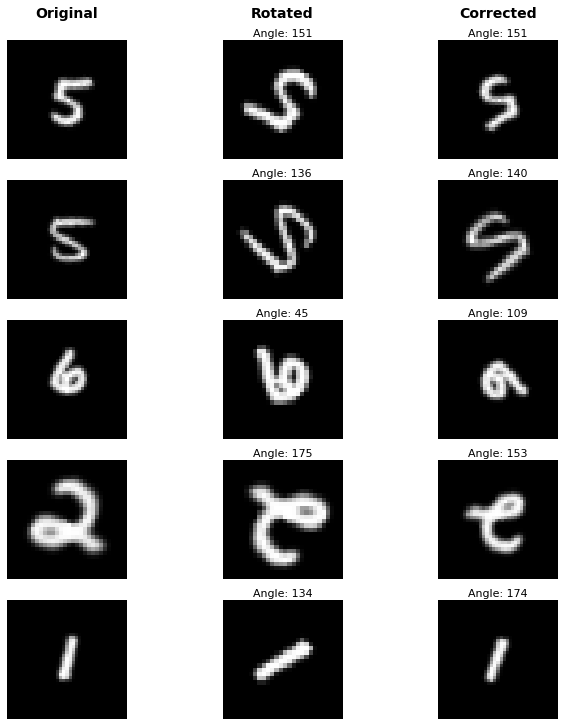

In [9]:
num_images = 5

display_examples(
    model, 
    X_test,
    num_images=num_images,
    preprocess_func=binarize_images,
)